### Density estimation using neural nets 

In this notebook I'll show how to fit a basic neural net to a circular dataset, attempting to discriminate between 4 different distributions: 
  * uniform 
  * von mises 
  * linear 
  * semicircular 
  
as defined in [Maddie Gaummer's thesis](https://scholarship.claremont.edu/hmc_theses/226/). I instantiate the neural net using [autograd](https://github.com/HIPS/autograd). In the sequel, I show how to fit a variety of hyperparameters using [Bayesian optimization](https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf), illustrating how model performance is affected by modulating various parameters related to the distributions themselves, as well as the neural net and optimization process.

In [1]:
import sys 
sys.path.append('../')
import numpy as np 
import pandas as pd
import numpy.random as npr
import seaborn as sns 
import matplotlib.pyplot as plt
from math import pi
from utils import make_data, plot_sample, train_test_split, one_hot_decoding, plot_distribution
from distributions import uniform, linear, semi_circular, von_mises
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd.scipy.special import logsumexp
from autograd import grad
from autograd.misc.flatten import flatten
from autograd.misc.optimizers import adam
from nnet import init_mlp_params, mlp_log_posterior
sns.set_style('white')
sns.set(rc={'figure.figsize':(18, 11)})
npr.seed(0)

I'll start with a simple example. These simulation parameters determine how many bins to use in partitioning the circle on which the distribution will be drawn, as well as how many points to sample for each distribution. 

The network parameters determine the layer sizes of the mlp, and the training parameters modulate various elements of the optimization procedure. 

In [4]:
# simulation parameters 
n_draws = 128   # number of draws from each distribution 
n_bins = 64      # number of bins in each distribution 

# network parameters 
layer_sizes = [n_bins, 64, 4]
L2_reg = 1.0

# training parameters
param_scale = 0.1
batch_size = 256
num_epochs = 75
step_size = 0.001

# data size 
n_data = 1000  # number of data per class

These are the methods which define a basic mlp. Note that all of these functions have docstrings defined in nnet.py, so one can simply run help(init_mlp_params) for information on what the method does. 

We define a method to intialize the network parameters, to generate predictions given a set of inputs, and methods related to the optimization of the parameters. The l2_norm method is used to penalize the length of the parameter vector, and the mlp_log_posterior computes

$$
p(\theta | y) = \frac{p(y | \theta)p(\theta)}{p(y)}
$$

In [5]:
# basic mlp 
def init_mlp_params(scale, layer_sizes, rs=npr.RandomState(0)):
    return [(scale * rs.randn(m, n),   # weight matrix
             scale * rs.randn(n))      # bias vector
            for m, n in zip(layer_sizes[:-1], layer_sizes[1:])]

def mlp_predict(params, inputs):
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = np.tanh(outputs)
    return outputs - logsumexp(outputs, axis=1, keepdims=True)

def l2_norm(params):
    flattened, _ = flatten(params)
    return np.dot(flattened, flattened)

def mlp_log_posterior(params, inputs, targets, L2_reg):
    log_prior = -L2_reg * l2_norm(params)
    log_lik = np.sum(mlp_predict(params, inputs) * targets)
    return log_prior + log_lik

def accuracy(params, inputs, targets):
    target_class    = np.argmax(targets, axis=1)
    predicted_class = np.argmax(mlp_predict(params, inputs), axis=1)
    return np.mean(predicted_class == target_class)

Here we can generate a set of sample data. Use split=True to automatically split the data into a training and test set. This takes about 15 seconds on my macbook (and is certainly not optimized). 

In [6]:
# generate data 
train_inputs, test_inputs, train_labels, test_labels = make_data(n_per_class=n_data, n_bins=n_bins, n_draws=n_draws, split=True)

.........................  [   25/1000,    0.02sec avg, ETA 16.87 ]
.........................  [   50/1000,    0.02sec avg, ETA 14.82 ]
.........................  [   75/1000,    0.02sec avg, ETA 14.98 ]
.........................  [  100/1000,    0.02sec avg, ETA 14.58 ]
.........................  [  125/1000,    0.02sec avg, ETA 14.96 ]
.........................  [  150/1000,    0.02sec avg, ETA 14.37 ]
.........................  [  175/1000,    0.02sec avg, ETA 13.92 ]
.........................  [  200/1000,    0.02sec avg, ETA 13.27 ]
.........................  [  225/1000,    0.02sec avg, ETA 12.87 ]
.........................  [  250/1000,    0.02sec avg, ETA 12.28 ]
.........................  [  275/1000,    0.02sec avg, ETA 11.71 ]
.........................  [  300/1000,    0.02sec avg, ETA 11.17 ]
.........................  [  325/1000,    0.02sec avg, ETA 10.66 ]
.........................  [  350/1000,    0.02sec avg, ETA 10.28 ]
.........................  [  375/1000,    0.02s

Use the plot_sample method to take a look at a few samples from the data. By default, plot_sample generates 4 samples randomly, but you can easily generate more using the loop below. 

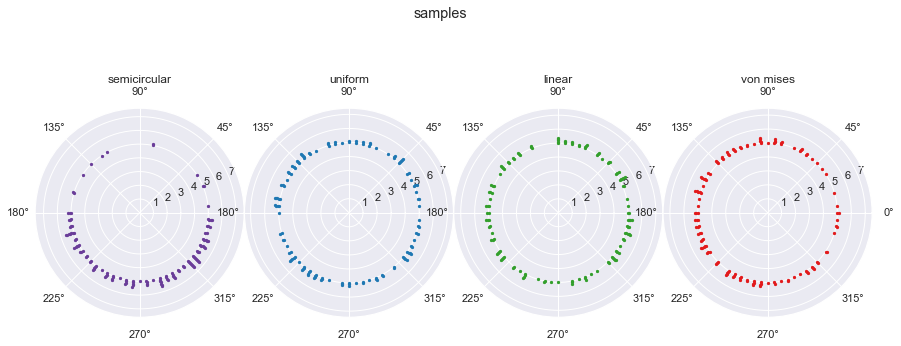

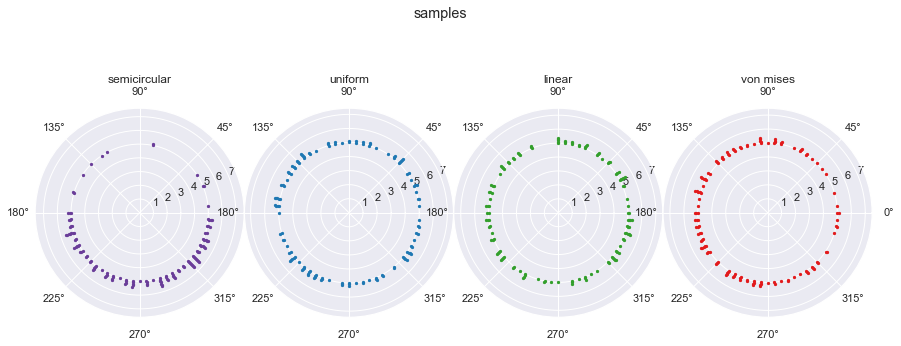

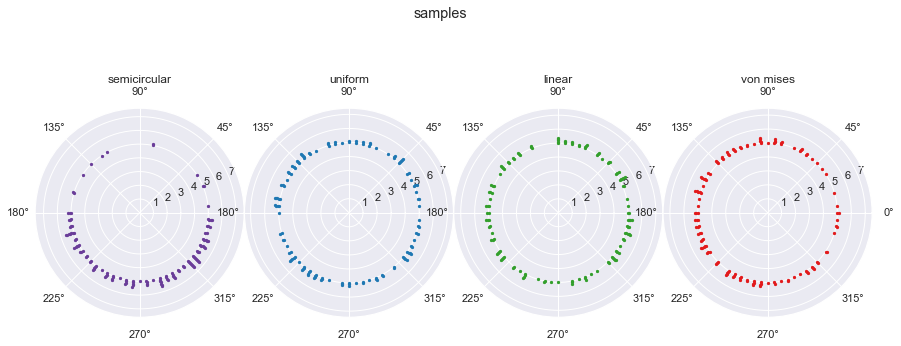

In [7]:
for _ in range(3): 
    plot_sample(train_inputs, train_labels)

Now we'll initialize the parameters of the neural net and train it.

     Epoch     |    Train accuracy  |       Test accuracy  
              0|            0.258125|             0.24625
              1|              0.3125|                0.28
              2|             0.35375|             0.31375
              3|           0.4359375|             0.37375
              4|           0.4828125|             0.40375
              5|             0.52875|              0.4475
              6|             0.56375|              0.4775
              7|            0.585625|                0.53
              8|               0.605|              0.5625
              9|            0.623125|             0.58375
             10|            0.646875|              0.5925
             11|           0.6640625|                0.61
             12|           0.6778125|                0.62
             13|            0.695625|             0.62875
             14|               0.705|                0.63
             15|            0.718125|             0.63375
            

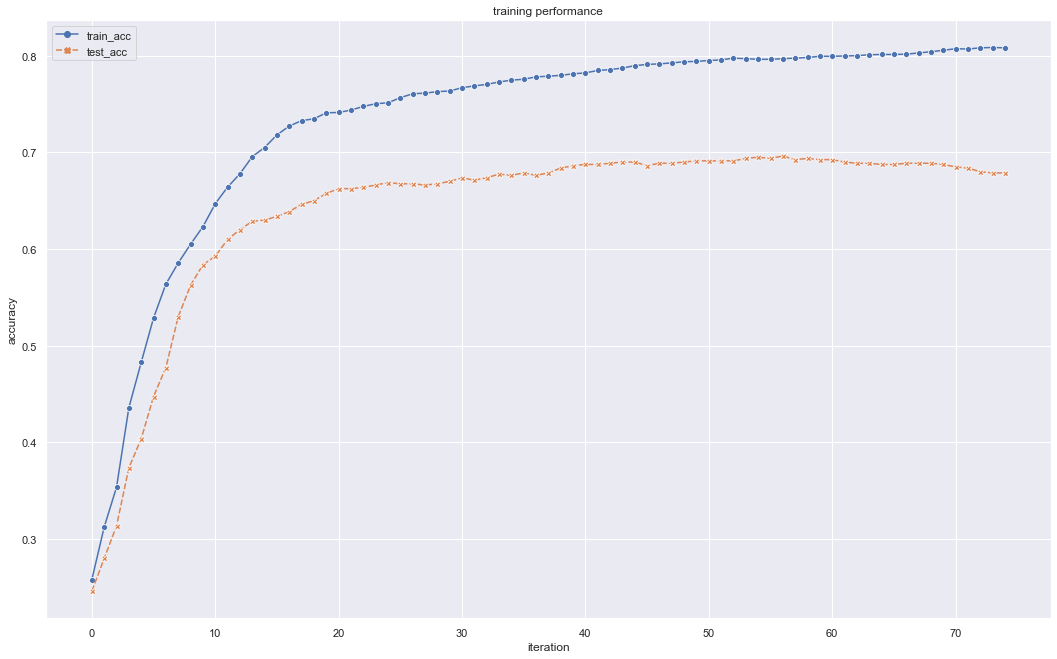

In [8]:
# initialize the net
init_params = init_mlp_params(param_scale, layer_sizes)

# batching parameters
num_batches = int(np.ceil(len(train_inputs) / batch_size))
def batch_indices(iter):
    idx = iter % num_batches
    return slice(idx * batch_size, (idx+1) * batch_size)

# define training objective: negative log marginal likelihood 
def objective(params, iter):
    idx = batch_indices(iter)
    return -mlp_log_posterior(params, train_inputs[idx], train_labels[idx], L2_reg)

# get gradient of objective using autograd
objective_grad = grad(objective)


# log training and test loss 
train_accs, test_accs = [], []  
print("     Epoch     |    Train accuracy  |       Test accuracy  ")

def print_perf(params, iter, gradient):
    if iter % num_batches == 0:
        train_acc = accuracy(params, train_inputs, train_labels)
        test_acc  = accuracy(params, test_inputs, test_labels)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        print("{:15}|{:20}|{:20}".format(iter//num_batches, train_acc, test_acc))

# The optimizers provided can optimize lists, tuples, or dicts of parameters.
optimized_params = adam(objective_grad, init_params, step_size=step_size,
                        num_iters=num_epochs * num_batches, callback=print_perf)

losses = pd.DataFrame(data=np.vstack((train_accs, test_accs)).T, columns=['train_acc', 'test_acc'])
ax = sns.lineplot(data=losses, markers=True)
ax.set(xlabel='iteration')
ax.set(ylabel='accuracy')
ax.set(title='training performance'); 